## Load iEEG and fMRI connectivity matrices

In [701]:
import os
from os.path import join as ospj
import json
import glob
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_theme(style='white')
import matplotlib.pyplot as plt
import warnings
import scipy.stats as stats
from scipy.stats import ttest_1samp
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None
import statsmodels.api as sm
import statsmodels.formula.api as smf
import bct
from bct import algorithms
import pickle

# Get current directory
code_path = os.getcwd()

# Get absolute path from config file
with open(ospj(code_path, "config.json"), "rb") as f:
    config = json.load(f)
repo_path = config["repoPath"]
ieeg_path = ospj(repo_path, "outputs", "ieeg")
fmri_path = ospj(repo_path, "outputs", "fmri_seg_masked")

# Load clinical variables
clin = pd.read_excel(ospj(repo_path, "source_data", "metadata", "noddi_demo_surgical_outcomes_updated_hupid.xlsx"))

# Define spherical ROI radiuses
radii = [8]

# Define states
states = ["interictal", "preictal", "ictal"]

# Define frequency bands
freq_bands = ["broadband", "delta", "theta", "alpha", "beta", "gamma"]

# Define iEEG connectivity types
ieeg_conn_types = ['pearson', 'spearman', 'coherence']
fmri_conn_types = ['pearson', 'spearman']

# Define tissue times
tissue_types = ['wm', 'gm']

# Create dictionaries
connectivity_ieeg = {}
connectivity_ieeg_distance_regressed = {}
connectivity_ieeg_mat = {}
connectivity_fmri = {}
connectivity_fmri_distance_regressed = {}
connectivity_fmri_mat = {}
distances_wm = {}
distances_wm_all = []
distances_gm = {}
distances_gm_all = []
num_electrodes = {}

# Load data
sub_dirs = glob.glob(ospj(fmri_path, "sub-*"))
for sub_dir in sub_dirs:

    sub = str(os.path.basename(sub_dir))
    
    # Omit subject for now
    if sub == 'sub-RID0050':
        continue
    
    print(sub)
    
    # Load electrode distances, vectorizing them, and saving to dictionary
    distances_wm_path = ospj(ieeg_path, sub, 'coords', str(sub) + '_wm_electrode_coords_euclidean.csv')
    distances_gm_path = ospj(ieeg_path, sub, 'coords', str(sub) + '_gm_electrode_coords_euclidean.csv')
    
    distances_wm_file = pd.read_csv(distances_wm_path)
    distances_gm_file = pd.read_csv(distances_gm_path)
    distances_wm_file.drop(distances_wm_file.columns[0], axis=1, inplace=True)
    distances_gm_file.drop(distances_gm_file.columns[0], axis=1, inplace=True)
    
    distances_wm_vectorized = distances_wm_file.values.flatten()
    distances_gm_vectorized = distances_gm_file.values.flatten()
    distances_wm_vectorized = distances_wm_vectorized[~np.isnan(distances_wm_vectorized)]
    distances_gm_vectorized = distances_gm_vectorized[~np.isnan(distances_gm_vectorized)]
    
    distances_wm[sub] = distances_wm_vectorized[~np.isnan(distances_wm_vectorized)]
    distances_gm[sub] = distances_gm_vectorized[~np.isnan(distances_gm_vectorized)]
    distances_wm_all.extend(distances_wm_vectorized[~np.isnan(distances_wm_vectorized)].tolist())
    distances_gm_all.extend(distances_gm_vectorized[~np.isnan(distances_gm_vectorized)].tolist())
    
    num_electrodes[sub] = {}
    
    # Create dictionaries for holding connectivity data
    sub_connectivity_ieeg = {}
    sub_connectivity_ieeg_distance_regressed = {}
    sub_connectivity_ieeg_mat = {}
    
    sub_connectivity_fmri = {}
    sub_connectivity_fmri_distance_regressed = {}
    sub_connectivity_fmri_mat = {}

    # Load iEEG data
    for tissue_type in tissue_types:

        sub_connectivity_ieeg[tissue_type] = {}
        sub_connectivity_ieeg_distance_regressed[tissue_type] = {}
        sub_connectivity_ieeg_mat[tissue_type] = {}
    
        for state in states:

            sub_connectivity_ieeg[tissue_type][state] = {}
            sub_connectivity_ieeg_distance_regressed[tissue_type][state] = {}
            sub_connectivity_ieeg_mat[tissue_type][state] = {}

            for band in freq_bands:

                sub_connectivity_ieeg[tissue_type][state][band] = {}
                sub_connectivity_ieeg_distance_regressed[tissue_type][state][band] = {}
                sub_connectivity_ieeg_mat[tissue_type][state][band] = {}            
            
                for conn_type in ieeg_conn_types:
            
                    file = pd.read_csv(ospj(ieeg_path, sub, "connectivity", state, sub + "_" + tissue_type + "_connectivity-" + conn_type + '_' + state + "_" + band + ".csv"))

                    # Extract electrode labels
                    labels = file.iloc[:,0]

                    num_electrodes[sub][tissue_type] = len(labels)
                    
                    # Remove column of labels
                    file.drop(file.columns[0], axis=1, inplace=True)

                    # Vectorize ieeg connectivity, removing NANs
                    connectivity_vectorized = file.values.flatten()
                    connectivity_vectorized = connectivity_vectorized[~np.isnan(connectivity_vectorized)]

                    # Regress out distance
                    if tissue_type == 'wm':
                        X = sm.add_constant(distances_wm[sub])
                    elif tissue_type == 'gm':
                        X = sm.add_constant(distances_gm[sub])
                    model = sm.OLS(connectivity_vectorized, X)
                    residuals = model.fit().resid

                    # Save connectivity
                    sub_connectivity_ieeg[tissue_type][state][band][conn_type] = connectivity_vectorized
                    sub_connectivity_ieeg_distance_regressed[tissue_type][state][band][conn_type] = residuals
                    sub_connectivity_ieeg_mat[tissue_type][state][band][conn_type] = file

    connectivity_ieeg[sub] = sub_connectivity_ieeg
    connectivity_ieeg_distance_regressed[sub] = sub_connectivity_ieeg_distance_regressed
    connectivity_ieeg_mat[sub] = sub_connectivity_ieeg_mat

    # Load fMRI data
    for tissue_type in tissue_types:

        sub_connectivity_fmri[tissue_type] = {}
        sub_connectivity_fmri_distance_regressed[tissue_type] = {}
        sub_connectivity_fmri_mat[tissue_type] = {}
        
        for radius in radii:
        
            sub_connectivity_fmri[tissue_type][radius] = {}
            sub_connectivity_fmri_distance_regressed[tissue_type][radius] = {}
            sub_connectivity_fmri_mat[tissue_type][radius] = {}
        
            for conn_type in fmri_conn_types:
        
                file = pd.read_csv(ospj(fmri_path, sub, "connectivity", sub + "_" + tissue_type + "_fmri_connectivity-" + conn_type + "_radius-" + str(radius) + "mm.csv"))

                # Extract electrode labels
                labels = file.iloc[:,0]

                # Remove column of labels
                file.drop(file.columns[0], axis=1, inplace=True)

                # Vectorize ieeg connectivity
                connectivity_vectorized = file.values.flatten()
                connectivity_vectorized = connectivity_vectorized[~np.isnan(connectivity_vectorized)]

                #print(sub + ' - ' + str(radius) + ' - ' + tissue_type)

                # Regress out distance
                if tissue_type == 'wm':
                    X = sm.add_constant(distances_wm[sub])
                elif tissue_type == 'gm':
                    X = sm.add_constant(distances_gm[sub])

                model = sm.OLS(connectivity_vectorized, X)
                residuals = model.fit().resid

                # Save connectivity
                sub_connectivity_fmri[tissue_type][radius][conn_type] = connectivity_vectorized
                sub_connectivity_fmri_distance_regressed[tissue_type][radius][conn_type] = residuals
                sub_connectivity_fmri_mat[tissue_type][radius][conn_type] = file

    connectivity_fmri[sub] = sub_connectivity_fmri
    connectivity_fmri_distance_regressed[sub] = sub_connectivity_fmri_distance_regressed
    connectivity_fmri_mat[sub] = sub_connectivity_fmri_mat
    

sub-RID0037


FileNotFoundError: [Errno 2] No such file or directory: '/Users/mjaskir/ngg/rotations/davis/iEEG_fMRI_WM/outputs/ieeg/sub-RID0037/coords/sub-RID0037_wm_electrode_coords_euclidean.csv'

### Plot sample fMRI connectivity matrix

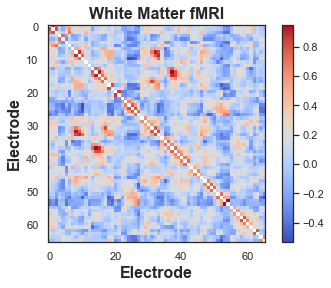

In [679]:
# Extract fMRI connectivity matrix
sample_fmri = connectivity_fmri_mat['sub-RID0139']['wm'][8]['pearson']
sample_fmri_sym = pd.DataFrame(np.tril(sample_fmri) + np.tril(sample_fmri, -1).T)

# Plot fMRI connectivity matrix
plt.imshow(sample_fmri_sym, cmap='coolwarm')
plt.xlabel('Electrode', fontsize=16, weight='bold')
plt.ylabel('Electrode', fontsize=16, weight='bold')
plt.title('White Matter fMRI',fontsize=16, weight='bold')
plt.colorbar()

### Plot sample iEEG connectivity matrix

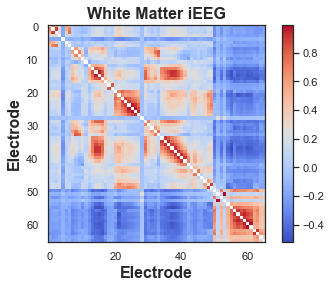

In [680]:
# Extract iEEG connectivity matrix
sample_ieeg = connectivity_ieeg_mat['sub-RID0139']['wm']['ictal']['broadband']['pearson']
sample_ieeg_sym = pd.DataFrame(np.tril(sample_ieeg) + np.tril(sample_ieeg, -1).T)

# Plot iEEG connectivity matrix
plt.imshow(sample_ieeg_sym, cmap='coolwarm')
plt.xlabel('Electrode', fontsize=16, weight='bold')
plt.ylabel('Electrode', fontsize=16, weight='bold')
plt.title('White Matter iEEG',fontsize=16, weight='bold')
plt.colorbar()

## Compare WM vs. GM electrode distances

In [681]:
print('Total number of white matter electrodes: ' + str(len(distances_wm_all)))
print('Total number of grey matter electrodes: ' + str(len(distances_gm_all)))

print('Converting electrode distance data into a single data frame...')

distances_df = pd.DataFrame(columns=['Subject', 'TissueType', 'Value'])

# Iterate over the keys and values of distances_wm
for subject, values in distances_wm.items():
    for value in values:
        # Append the row to the DataFrame
        distances_df = distances_df.append({'Subject': subject, 'TissueType': 'wm', 'Value': value}, ignore_index=True)

# Iterate over the keys and values of distances_gm
for subject, values in distances_gm.items():
    for value in values:
        # Append the row to the DataFrame
        distances_df = distances_df.append({'Subject': subject, 'TissueType': 'gm', 'Value': value}, ignore_index=True)

print('Done!')

# Fit the linear mixed effects regression model
model = smf.mixedlm("Value ~ TissueType", data=distances_df, groups=distances_df["Subject"]).fit()

# Print the model summary
print(model.summary())

Total number of white matter electrodes: 48209
Total number of grey matter electrodes: 41407
Converting electrode distance data into a single data frame...
Done!


/Users/mjaskir/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/mjaskir/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


            Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  Value       
No. Observations:  89616    Method:              REML        
No. Groups:        32       Scale:               1172.6976   
Min. group size:   291      Log-Likelihood:      -443918.2286
Max. group size:   7309     Converged:           Yes         
Mean group size:   2800.5                                    
-------------------------------------------------------------
                  Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept         68.269    3.001  22.749 0.000 62.388 74.151
TissueType[T.wm]  -6.210    0.254 -24.494 0.000 -6.707 -5.713
Group Var        286.972    2.562                            



### Plot differences in electrode distances

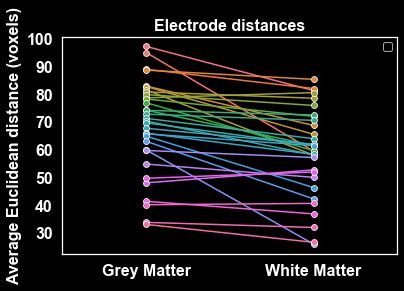

t:-5.331979290018428p8.28914669150733e-06


In [682]:
plt.style.use('dark_background')

# Average within subject and tissue type, converting to data frame
distances_avg = distances_df.groupby(['Subject', 'TissueType'], as_index=False)['Value'].mean()

# Sort the DataFrame based on 'gm' values
distances_avg_sorted = distances_avg.sort_values('Value', ascending=False)

distances_avg_sorted.loc[:,'TissueType'] = distances_avg_sorted.loc[:,'TissueType'].replace({'gm': 'Grey Matter',
                                                   'wm': 'White Matter'});

subjects_sorted = distances_avg_sorted['Subject'].unique()

# Plot the line plot
sns.lineplot(x='TissueType', y='Value', hue='Subject', data=distances_avg_sorted, marker='o')

# Customize the plot
plt.xlabel('', fontsize=16, weight='bold')
plt.xticks(fontsize=16, weight='bold')
plt.yticks(fontsize=16, weight='bold')
plt.ylabel('Average Euclidean distance (voxels)', fontsize=16, weight='bold')
#plt.legend(title='Subject', ncol=2, loc='right', bbox_to_anchor=(1.6, 0.5), fontsize=8, labels=subjects_sorted)
plt.legend('')
plt.title('Electrode distances', fontsize=16, weight='bold')
# Adjust the x-axis limits
plt.xlim(-0.5, 1.5)

# Show the plot
plt.show()

# Print the results of the paired t-test
paired_t = stats.ttest_rel(distances_avg[distances_avg['TissueType'] == 'wm']['Value'], distances_avg[distances_avg['TissueType'] == 'gm']['Value'])

# Print the results of the paired t-test
print('t:' + str(paired_t.statistic) + 'p' + str(paired_t.pvalue))


## Compute iEEG-fMRI correlations

### Save subject-level iEEG-fMRI correlations

In [683]:
# Compute correlation between iEEG and fMRI connectivity at the subject-level for each spherical ROI radius (radius), seizure state (ieeg), frequency band (band), tissue type (tissue_type_fmri & tissue_type_ieeg) and connectivity type (conn_type)
# Keys: ieeg_fmri_corr_sub[sub, radius, state, band]
ieeg_fmri_corr_sub = {}
ieeg_fmri_corr_sub_distance_regressed = {}
for sub in connectivity_ieeg.keys():
    
    ieeg_fmri_corr_sub[sub] = {}
    ieeg_fmri_corr_sub_distance_regressed[sub] = {}

    for tissue_type in connectivity_fmri[sub].keys():

        ieeg_fmri_corr_sub[sub][tissue_type] = {}
        ieeg_fmri_corr_sub_distance_regressed[sub][tissue_type] = {}
        
        for radius in connectivity_fmri[sub][tissue_type].keys():

            ieeg_fmri_corr_sub[sub][tissue_type][radius] = {}
            ieeg_fmri_corr_sub_distance_regressed[sub][tissue_type][radius] = {}
            
            for fmri_conn_type in connectivity_fmri[sub][tissue_type][radius].keys():

                ieeg_fmri_corr_sub[sub][tissue_type][radius][fmri_conn_type] = {}
                ieeg_fmri_corr_sub_distance_regressed[sub][tissue_type][radius][fmri_conn_type] = {}

                # Vectorize iEEG connectivity matrices
                for state in connectivity_ieeg[sub][tissue_type].keys():

                    ieeg_fmri_corr_sub[sub][tissue_type][radius][fmri_conn_type][state] = {}
                    ieeg_fmri_corr_sub_distance_regressed[sub][tissue_type][radius][fmri_conn_type][state] = {}

                    for band in connectivity_ieeg[sub][tissue_type][state].keys():

                        ieeg_fmri_corr_sub[sub][tissue_type][radius][fmri_conn_type][state][band] = {}
                        ieeg_fmri_corr_sub_distance_regressed[sub][tissue_type][radius][fmri_conn_type][state][band] = {}
                        
                        for ieeg_conn_type in connectivity_ieeg[sub][tissue_type][state][band].keys():

                            # Compute correlation
                            ieeg_fmri_corr_sub[sub][tissue_type][radius][fmri_conn_type][state][band][ieeg_conn_type] = np.corrcoef(connectivity_fmri[sub][tissue_type][radius][fmri_conn_type], connectivity_ieeg[sub][tissue_type][state][band][ieeg_conn_type])[0,1]
                            ieeg_fmri_corr_sub_distance_regressed[sub][tissue_type][radius][fmri_conn_type][state][band][ieeg_conn_type] = np.corrcoef(connectivity_fmri_distance_regressed[sub][tissue_type][radius][fmri_conn_type], connectivity_ieeg_distance_regressed[sub][tissue_type][state][band][ieeg_conn_type])[0,1]
                            
                            
                            

### Convert to dataframe

In [684]:
# Across subjects average iEEG-fMRI correlations by 1) radius, 2) seizure state, and 3) and frequency band
ieeg_fmri_corrs = {} 
ieeg_fmri_corrs_distance_regressed = {} 
for tissue_type in tissue_types:

    ieeg_fmri_corrs[tissue_type] = {}
    ieeg_fmri_corrs_distance_regressed[tissue_type] = {}

    for radius in radii:
        
        ieeg_fmri_corrs[tissue_type][radius] = {}
        ieeg_fmri_corrs_distance_regressed[tissue_type][radius] = {}

        for fmri_conn_type in fmri_conn_types:

            ieeg_fmri_corrs[tissue_type][radius][fmri_conn_type] = {}
            ieeg_fmri_corrs_distance_regressed[tissue_type][radius][fmri_conn_type] = {}
    
            for state in states:

                ieeg_fmri_corrs[tissue_type][radius][fmri_conn_type][state] = {}
                ieeg_fmri_corrs_distance_regressed[tissue_type][radius][fmri_conn_type][state] = {}

                for band in freq_bands:

                    ieeg_fmri_corrs[tissue_type][radius][fmri_conn_type][state][band] = {}
                    ieeg_fmri_corrs_distance_regressed[tissue_type][radius][fmri_conn_type][state][band] = {}

                    for ieeg_conn_type in ieeg_conn_types:

                        corrs = []
                        corrs_distance_regressed = []
                        for sub in ieeg_fmri_corr_sub.keys():

                            corrs.append(ieeg_fmri_corr_sub[sub][tissue_type][radius][fmri_conn_type][state][band][ieeg_conn_type])
                            corrs_distance_regressed.append(ieeg_fmri_corr_sub_distance_regressed[sub][tissue_type][radius][fmri_conn_type][state][band][ieeg_conn_type])

                        ieeg_fmri_corrs[tissue_type][radius][fmri_conn_type][state][band][ieeg_conn_type] = corrs
                        ieeg_fmri_corrs_distance_regressed[tissue_type][radius][fmri_conn_type][state][band][ieeg_conn_type] = corrs_distance_regressed

# Define function to convert nested dictionary to a flattened pandas dataframe
def flatten_dict(nested_dict):
    res = {}
    if isinstance(nested_dict, dict):
        for k in nested_dict:
            flattened_dict = flatten_dict(nested_dict[k])
            for key, val in flattened_dict.items():
                key = list(key)
                key.insert(0, k)
                res[tuple(key)] = val
    else:
        res[()] = nested_dict
    return pd.DataFrame(res)

# Convert nested dictionary to a flattened pandas dataframe
ieeg_fmri_corrs_flat = flatten_dict(ieeg_fmri_corrs)
ieeg_fmri_corrs_distance_regressed_flat = flatten_dict(ieeg_fmri_corrs_distance_regressed)


# Melt dataframe
ieeg_fmri_corrs_df = ieeg_fmri_corrs_flat.reset_index().melt(id_vars='index')
ieeg_fmri_corrs_distance_regressed_df = ieeg_fmri_corrs_distance_regressed_flat.reset_index().melt(id_vars='index')

# Clean up and rename variables
ieeg_fmri_corrs_df = ieeg_fmri_corrs_df.drop(columns=['variable_6'])
ieeg_fmri_corrs_df.drop(['index'], axis=1, inplace=True)
ieeg_fmri_corrs_df.rename(columns={'variable_0': 'tissue_type',
                                     'variable_1': 'radius', 
                                     'variable_2': 'fmri_conn_type', 
                                     'variable_3': 'state', 
                                     'variable_4': 'freq_band', 
                                     'variable_5': 'ieeg_conn_type', 
                                     'value': 'corr'}, inplace=True);

ieeg_fmri_corrs_distance_regressed_df = ieeg_fmri_corrs_distance_regressed_df.drop(columns=['variable_6'])
ieeg_fmri_corrs_distance_regressed_df.drop(['index'], axis=1, inplace=True)
ieeg_fmri_corrs_distance_regressed_df.rename(columns={'variable_0': 'tissue_type',
                                     'variable_1': 'radius', 
                                     'variable_2': 'fmri_conn_type', 
                                     'variable_3': 'state', 
                                     'variable_4': 'freq_band', 
                                     'variable_5': 'ieeg_conn_type', 
                                     'value': 'corr'}, inplace=True);

# Compute average correlations across subjects
ieeg_fmri_corrs_avg = ieeg_fmri_corrs_df.groupby(['tissue_type', 'radius', 'fmri_conn_type', 'state', 'freq_band', 'ieeg_conn_type']).mean()['corr']
ieeg_fmri_corrs_avg_df = pd.melt(ieeg_fmri_corrs_avg.reset_index(), id_vars=['tissue_type', 'radius', 'fmri_conn_type', 'state', 'freq_band', 'ieeg_conn_type'], value_name='corr')
ieeg_fmri_corrs_avg_df.drop(['variable'], axis=1, inplace=True)


## Compare magnitude of iEEG-fMRI correlations for different combinations of connectivity types

### Evaluate all combinations of unimodal connectivity types for the interictal broadband and alpha iEEG

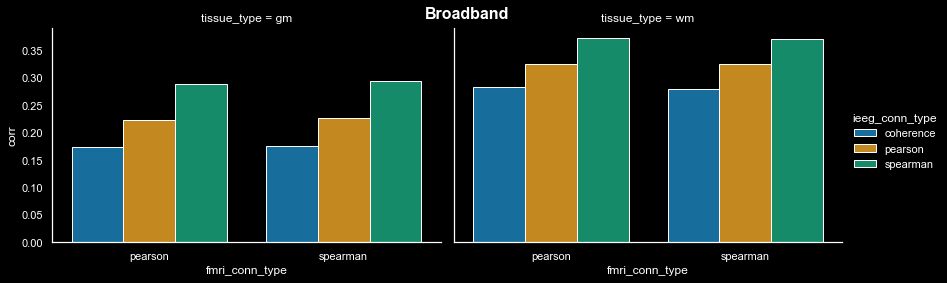

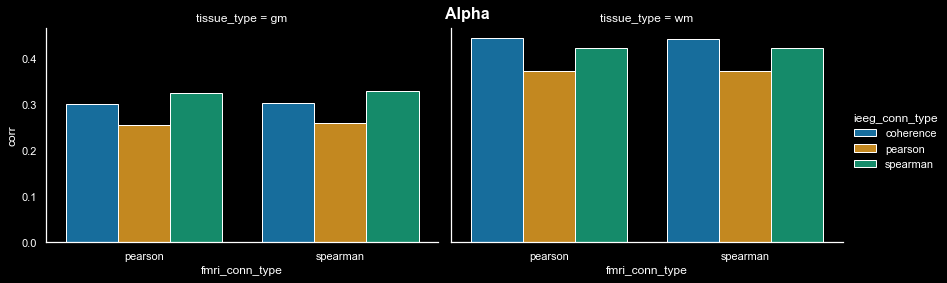

In [685]:
# Consider interictal, broadband connectivity
ieeg_fmri_corrs_avg_df_subset = ieeg_fmri_corrs_avg_df.loc[(ieeg_fmri_corrs_avg_df['state'] == 'interictal') & (ieeg_fmri_corrs_avg_df['freq_band'] == 'broadband')]

# Plot a bar graph of the average correlations grouping by each combination of 'fmri_conn_type', 'ieeg_conn_type', and 'tissue_type'. Add 'Broadband' as the title
sns.catplot(x='fmri_conn_type', y='corr', hue='ieeg_conn_type', col='tissue_type', data=ieeg_fmri_corrs_avg_df_subset, kind='bar', palette='colorblind', height=4, aspect=1.5)
plt.suptitle('Broadband', fontsize=16, weight='bold')


# Now consider interictal, alpha connectivity
ieeg_fmri_corrs_avg_df_subset = ieeg_fmri_corrs_avg_df.loc[(ieeg_fmri_corrs_avg_df['state'] == 'interictal') & (ieeg_fmri_corrs_avg_df['freq_band'] == 'alpha')]

# Plot a bar graph of the average correlations grouping by each combination of 'fmri_conn_type', 'ieeg_conn_type', and 'tissue_type'. Add 'Broadband' as the title
sns.catplot(x='fmri_conn_type', y='corr', hue='ieeg_conn_type', col='tissue_type', data=ieeg_fmri_corrs_avg_df_subset, kind='bar', palette='colorblind', height=4, aspect=1.5)
plt.suptitle('Alpha', fontsize=16, weight='bold');

### Fixing fMRI connectivity as Spearman

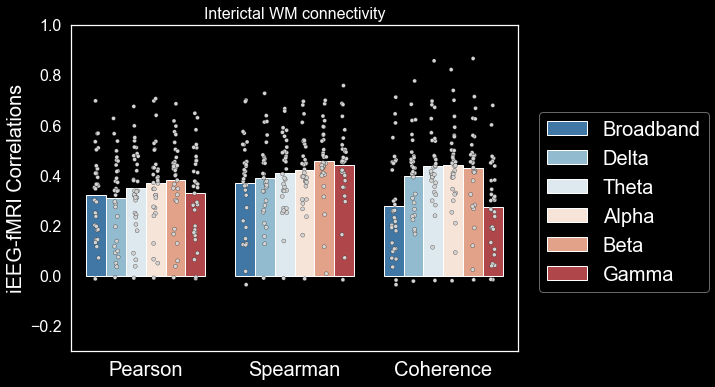

In [186]:
# Filter data frame
df = ieeg_fmri_corrs_df[ieeg_fmri_corrs_df['state'] == 'interictal']
df = df[df['radius'] == 8]
df = df[df['tissue_type'] == 'wm']
df = df[df['fmri_conn_type'] == 'spearman']

# Update state variable names
df.loc[:,'state'] = df.loc[:,'state'].replace({'ictal': 'Ictal'});
df.loc[:,'freq_band'] = df.loc[:,'freq_band'].replace({'broadband': 'Broadband',
                                               'delta': 'Delta',
                                               'theta': 'Theta', 
                                               'alpha': 'Alpha',
                                               'beta': 'Beta',
                                               'gamma': 'Gamma'});
df.loc[:,'ieeg_conn_type'] = df.loc[:,'ieeg_conn_type'].replace({'pearson': 'Pearson',
                                                      'spearman': 'Spearman', 
                                                      'coherence': 'Coherence'});

# Create the grouped bar graph with overlaid scatter plot
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x='ieeg_conn_type', y='corr', hue='freq_band', data=df, palette='RdBu_r', ci=None)
sns.stripplot(x='ieeg_conn_type', y='corr', hue='freq_band', data=df, palette=['lightgrey','lightgrey','lightgrey','lightgrey','lightgrey','lightgrey'], jitter=True, dodge=True, s=4, edgecolor='black', linewidth=0.25)

# Set the title and axis labels
plt.title('Interictal WM connectivity', fontsize=16)
plt.xticks(fontsize=20)
plt.yticks(fontsize=16)
plt.xlabel('', fontsize=16)
plt.ylabel('iEEG-fMRI Correlations', fontsize=20)
plt.ylim([-0.3,1])

# Extract handles and labels
handles, labels = ax.get_legend_handles_labels()

# Set the legend location and format
plt.legend(handles[6:12], labels[0:6], loc='lower right', fancybox=True, framealpha=0.5, fontsize=20, ncol=1, bbox_to_anchor=(1.45, 0.15))

# Show the plot
plt.show()

## Effect of tissue type

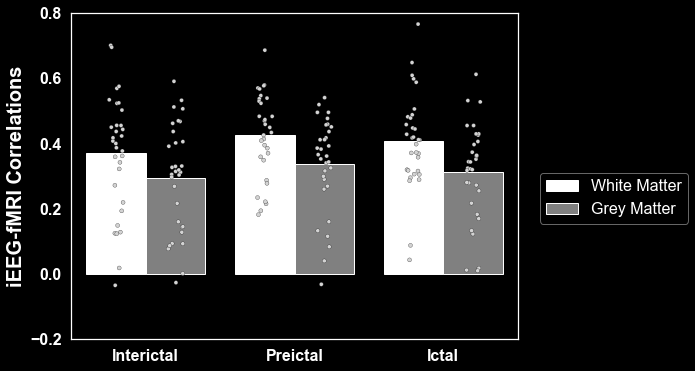

In [686]:
plt.style.use('dark_background')

# Filter data frame
df = ieeg_fmri_corrs_df[ieeg_fmri_corrs_df['state'].isin(['ictal','preictal','interictal'])]
df = df[df['radius'] == 8]
df = df[df['fmri_conn_type'] == 'spearman']
df = df[df['ieeg_conn_type'] == 'spearman']
df = df[df['freq_band'] == 'broadband']

# Update variable names
df.loc[:,'state'] = df.loc[:,'state'].replace({'interictal': 'Interictal',
                                               'preictal': 'Preictal',
                                               'ictal': 'Ictal'});
df.loc[:,'freq_band'] = df.loc[:,'freq_band'].replace({'broadband': 'Broadband',
                                           'delta': 'Delta',
                                           'theta': 'Theta', 
                                           'alpha': 'Alpha',
                                           'beta': 'Beta',
                                           'gamma': 'Gamma'});
df.loc[:,'tissue_type'] = df.loc[:,'tissue_type'].replace({'wm': 'White Matter', 'gm': 'Grey Matter'});

# Create the grouped bar graph with overlaid scatter plot
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x='state', y='corr', hue='tissue_type', data=df, palette=['white', 'gray'], ci=None)
sns.stripplot(x='state', y='corr', hue='tissue_type', data=df, palette=['lightgrey','lightgrey','lightgrey','lightgrey','lightgrey','lightgrey'], jitter=True, dodge=True, s=4, edgecolor='black', linewidth=0.25)

# Set the title and axis labels
plt.xticks(fontsize=16, weight='bold')
plt.yticks(fontsize=16, weight='bold')
plt.xlabel('', fontsize=16)
plt.ylabel('iEEG-fMRI Correlations', fontsize=20, weight='bold')
plt.ylim([-0.2,0.8])
plt.title('', fontsize=16, weight='bold')

# Extract handles and labels
handles, labels = ax.get_legend_handles_labels()

# Set the legend location and format
plt.legend(handles[2:4], labels[2:4], loc='lower right', fancybox=True, framealpha=0.5, fontsize=16, ncol=1, bbox_to_anchor=(1.4, 0.33))

# Show the plot
plt.show()

Run stats

In [687]:
def compute_cohens_d(sample1, sample2):
    mean_diff = np.mean(sample1) - np.mean(sample2)
    pooled_std = np.sqrt(((len(sample1) - 1) * np.std(sample1)**2 + (len(sample2) - 1) * np.std(sample2)**2) / (len(sample1) + len(sample2) - 2))
    d = mean_diff / pooled_std
    return d

for state in states:

    df = ieeg_fmri_corrs_df[ieeg_fmri_corrs_df['state'] == state]
    df = df[df['radius'] == 8]
    df = df[df['fmri_conn_type'] == 'spearman']
    df = df[df['ieeg_conn_type'] == 'spearman']
    df = df[df['freq_band'] == 'broadband']

    # Subset the data by tissue type
    wm_corr = df[df['tissue_type'] == 'wm']['corr']
    gm_corr = df[df['tissue_type'] == 'gm']['corr']

    # Perform the t-test
    t_statistic, p_value = stats.ttest_ind(wm_corr, gm_corr)
    effect_size = compute_cohens_d(wm_corr, gm_corr)

    # Print the results
    print(state)
    print("Test statistic: ", t_statistic)
    print("P-value: ", p_value)
    print("Degrees of freedom: ", len(wm_corr) + len(gm_corr) - 2)
    print("Effect size (Cohen's d):", effect_size)
    print("")

interictal
Test statistic:  1.7755999355538215
P-value:  0.08070652670166342
Degrees of freedom:  62
Effect size (Cohen's d): 0.45100283463373086

preictal
Test statistic:  2.6108064418621435
P-value:  0.011312791261007166
Degrees of freedom:  62
Effect size (Cohen's d): 0.6631454993788153

ictal
Test statistic:  2.5430307621656234
P-value:  0.01349913605522485
Degrees of freedom:  62
Effect size (Cohen's d): 0.6459304595208508



### Repeating with distance regressed out

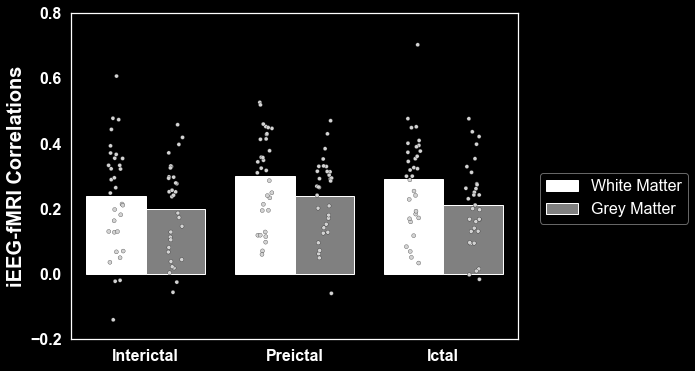

In [688]:
plt.style.use('dark_background')

# Filter data frame
df = ieeg_fmri_corrs_distance_regressed_df[ieeg_fmri_corrs_distance_regressed_df['state'].isin(['ictal','preictal','interictal'])]
df = df[df['radius'] == 8]
df = df[df['fmri_conn_type'] == 'spearman']
df = df[df['ieeg_conn_type'] == 'spearman']
df = df[df['freq_band'] == 'broadband']

# Update state variable names
df.loc[:,'state'] = df.loc[:,'state'].replace({'interictal': 'Interictal',
                                               'preictal': 'Preictal',
                                               'ictal': 'Ictal'});
df.loc[:,'freq_band'] = df.loc[:,'freq_band'].replace({'broadband': 'Broadband',
                                           'delta': 'Delta',
                                           'theta': 'Theta', 
                                           'alpha': 'Alpha',
                                           'beta': 'Beta',
                                           'gamma': 'Gamma'});
df.loc[:,'tissue_type'] = df.loc[:,'tissue_type'].replace({'wm': 'White Matter', 'gm': 'Grey Matter'});

# Create the grouped bar graph with overlaid scatter plot
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x='state', y='corr', hue='tissue_type', data=df, palette=['white', 'gray'], ci=None)
sns.stripplot(x='state', y='corr', hue='tissue_type', data=df, palette=['lightgrey','lightgrey','lightgrey','lightgrey','lightgrey','lightgrey'], jitter=True, dodge=True, s=4, edgecolor='black', linewidth=0.25)

# Set the title and axis labels
plt.xticks(fontsize=16, weight='bold')
plt.yticks(fontsize=16, weight='bold')
plt.xlabel('', fontsize=16)
plt.ylabel('iEEG-fMRI Correlations', fontsize=20, weight='bold')
plt.ylim([-0.2,0.8])
plt.title('', fontsize=16, weight='bold')

# Extract handles and labels
handles, labels = ax.get_legend_handles_labels()

# Set the legend location and format
plt.legend(handles[2:4], labels[2:4], loc='lower right', fancybox=True, framealpha=0.5, fontsize=16, ncol=1, bbox_to_anchor=(1.4, 0.33))

plt.show()

Run stats

In [689]:
for state in states:
    df = ieeg_fmri_corrs_distance_regressed_df[ieeg_fmri_corrs_distance_regressed_df['state'] == state]
    df = df[df['radius'] == 8]
    df = df[df['fmri_conn_type'] == 'spearman']
    df = df[df['ieeg_conn_type'] == 'spearman']
    df = df[df['freq_band'] == 'broadband']

    # Subset the data by tissue type
    wm_corr = df[df['tissue_type'] == 'wm']['corr']
    gm_corr = df[df['tissue_type'] == 'gm']['corr']

    # Perform the t-test
    t_statistic, p_value = stats.ttest_ind(wm_corr, gm_corr)
    effect_size = compute_cohens_d(wm_corr, gm_corr)

    # Print the results
    print(state)
    print("Test statistic: ", t_statistic)
    print("P-value: ", p_value)
    print("Degrees of freedom: ", len(wm_corr) + len(gm_corr) - 2)
    print("Effect size (Cohen's d):", effect_size)
    print("")

interictal
Test statistic:  1.0379882550224673
P-value:  0.30330682930755454
Degrees of freedom:  62
Effect size (Cohen's d): 0.2636492804251189

preictal
Test statistic:  1.9291325629622156
P-value:  0.058294623269390014
Degrees of freedom:  62
Effect size (Cohen's d): 0.4900001609928088

ictal
Test statistic:  2.3468434873136483
P-value:  0.022142547831665537
Degrees of freedom:  62
Effect size (Cohen's d): 0.5960988418768066



## Effect of frequency band

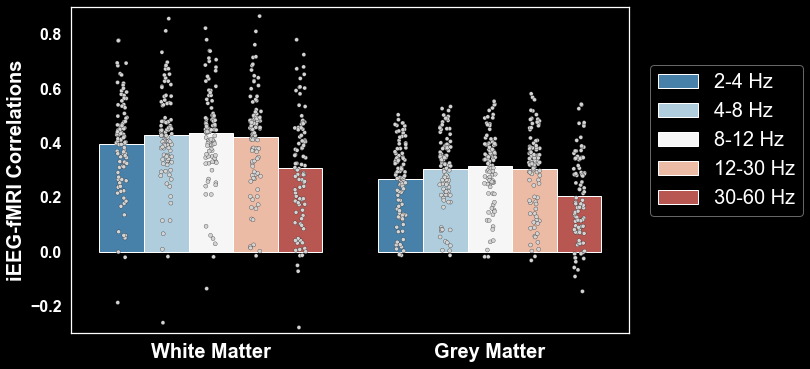

In [690]:
plt.style.use('dark_background')

df = ieeg_fmri_corrs_df[ieeg_fmri_corrs_df['state'].isin(['ictal','preictal','interictal'])]
df = df[df['radius'] == 8]
df = df[df['fmri_conn_type'] == 'spearman']
df = df[df['ieeg_conn_type'] == 'coherence']

# Update state variable names
df.loc[:,'state'] = df.loc[:,'state'].replace({'interictal': 'Interictal',
                                               'preictal': 'Preictal',
                                               'ictal': 'Ictal'});
df.loc[:,'freq_band'] = df.loc[:,'freq_band'].replace({'broadband': 'Broadband',
                                           'delta': '2-4 Hz',
                                           'theta': '4-8 Hz', 
                                           'alpha': '8-12 Hz',
                                           'beta': '12-30 Hz',
                                           'gamma': '30-60 Hz'});
df.loc[:,'tissue_type'] = df.loc[:,'tissue_type'].replace({'wm': 'White Matter', 'gm': 'Grey Matter'});

# Drop broadband
df = df[df['freq_band'] != 'Broadband']

# Create the grouped bar graph with overlaid scatter plot
fig, ax = plt.subplots(figsize=(10, 6))

# Grouped by frequency band
#sns.barplot(x='freq_band', y='corr', hue='tissue_type', data=df, palette=['white', 'gray'], ci=None)
#sns.stripplot(x='freq_band', y='corr', hue='tissue_type', data=df, palette=['lightgrey','lightgrey','lightgrey','lightgrey','lightgrey','lightgrey'], jitter=True, dodge=True, s=4, edgecolor='black', linewidth=0.25)
#plt.xlabel('Frequency band (Hz)', fontsize=16, weight='bold')

# Grouped by tissue type
sns.barplot(x='tissue_type', y='corr', hue='freq_band', data=df,  palette='RdBu_r', ci=None)
sns.stripplot(x='tissue_type', y='corr', hue='freq_band', data=df, palette=['lightgrey','lightgrey','lightgrey','lightgrey','lightgrey','lightgrey'], jitter=True, dodge=True, s=4, edgecolor='black', linewidth=0.25)
plt.xlabel('', fontsize=16, weight='bold')

# Set the title and axis labels
plt.xticks(fontsize=20, weight='bold')
plt.yticks(fontsize=16, weight='bold')
plt.ylabel('iEEG-fMRI Correlations', fontsize=20, weight='bold')
plt.ylim([-0.3,0.9])

# Extract handles and labels
handles, labels = ax.get_legend_handles_labels()

# Set the legend location and format
plt.legend(handles[5:], labels, loc='lower right', fancybox=True, framealpha=0.5, fontsize=20, ncol=1, bbox_to_anchor=(1.33, 0.33))

# Show the plot
plt.show()

### Repeating with distance regressed out

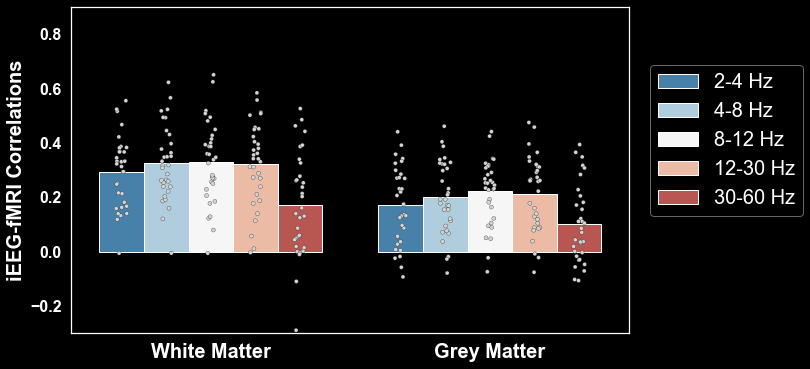

Mean alpha iEEG-fMRI correlation in white matter: 0.3315269425404511


In [691]:
plt.style.use('dark_background')

#df = ieeg_fmri_corrs_distance_regressed_df[ieeg_fmri_corrs_distance_regressed_df['state'].isin(['ictal','preictal','interictal'])]
df = ieeg_fmri_corrs_distance_regressed_df[ieeg_fmri_corrs_distance_regressed_df['state'] == 'interictal']

df = df[df['radius'] == 8]
df = df[df['fmri_conn_type'] == 'spearman']
df = df[df['ieeg_conn_type'] == 'coherence']

# Update state variable names
df.loc[:,'state'] = df.loc[:,'state'].replace({'interictal': 'Interictal',
                                               'preictal': 'Preictal',
                                               'ictal': 'Ictal'});
df.loc[:,'freq_band'] = df.loc[:,'freq_band'].replace({'broadband': 'Broadband',
                                           'delta': '2-4 Hz',
                                           'theta': '4-8 Hz', 
                                           'alpha': '8-12 Hz',
                                           'beta': '12-30 Hz',
                                           'gamma': '30-60 Hz'});
df.loc[:,'tissue_type'] = df.loc[:,'tissue_type'].replace({'wm': 'White Matter', 'gm': 'Grey Matter'});

# Drop broadband
df = df[df['freq_band'] != 'Broadband']

# Create the grouped bar graph with overlaid scatter plot
fig, ax = plt.subplots(figsize=(10, 6))

# Grouped by frequency band
#sns.barplot(x='freq_band', y='corr', hue='tissue_type', data=df, palette=['white', 'gray'], ci=None)
#sns.stripplot(x='freq_band', y='corr', hue='tissue_type', data=df, palette=['lightgrey','lightgrey','lightgrey','lightgrey','lightgrey','lightgrey'], jitter=True, dodge=True, s=4, edgecolor='black', linewidth=0.25)
#plt.xlabel('Frequency band (Hz)', fontsize=16, weight='bold')

# Grouped by tissue type
sns.barplot(x='tissue_type', y='corr', hue='freq_band', data=df,  palette='RdBu_r', ci=None)
sns.stripplot(x='tissue_type', y='corr', hue='freq_band', data=df, palette=['lightgrey','lightgrey','lightgrey','lightgrey','lightgrey','lightgrey'], jitter=True, dodge=True, s=4, edgecolor='black', linewidth=0.25)
plt.xlabel('', fontsize=16, weight='bold')

# Set the title and axis labels
plt.xticks(fontsize=20, weight='bold')
plt.yticks(fontsize=16, weight='bold')
plt.ylabel('iEEG-fMRI Correlations', fontsize=20, weight='bold')
plt.ylim([-0.3,0.9])

# Extract handles and labels
handles, labels = ax.get_legend_handles_labels()

# Set the legend location and format
plt.legend(handles[5:], labels, loc='lower right', fancybox=True, framealpha=0.5, fontsize=20, ncol=1, bbox_to_anchor=(1.33, 0.33))

# Remove grid lines
ax.grid(False)

# Show the plot
plt.show()

# Print mean alpha iEEG-fMRI correlation in white matter
alpha_corr_df = df[(df['radius'] == 8) & 
                   (df['freq_band'] == '8-12 Hz') & 
                   (df['tissue_type'] == 'White Matter') & 
                   (df['fmri_conn_type'] == 'spearman') & 
                   (df['ieeg_conn_type'] == 'coherence') & 
                   (df['state'] == 'Interictal')]

# Print mean alpha iEEG-fMRI correlation in white matter
print('Mean alpha iEEG-fMRI correlation in white matter: ' + str(np.mean(alpha_corr_df['corr'])))


## Graph properties

### Save graph measures separately by modality

In [692]:
#fmri_graph[sub]['cluster_coef'] = np.mean(algorithms.clustering_coef_wd(np.array(file_sym)))
#fmri_graph[sub]['global_efficiency'] = algorithms.efficiency_wei(np.array(file_sym), local=False)

#sub_connectivity_ieeg_distance_regressed
#sub_connectivity_fmri_distance_regressed

# Convert vectorized connectivity matrix into symmetric
def vec_to_sym_matrix(vec):

    n = int(np.sqrt(2 * len(vec))) + 1  # Determine the size of the matrix
    matrix = np.zeros((n, n))  # Create an empty matrix

    tril_indices = np.tril_indices(n, k=-1)  # Get the indices of the lower triangle

    matrix[tril_indices] = vec # Fill the lower triangle of the matrix with the vectorized matrix
    matrix_sym = matrix + matrix.T # Add the transpose of the matrix to the matrix to make it symmetric

    return matrix_sym

graph_measures = ['global_efficiency', 'cluster_coef', 'modularity']

print('Computing network measures for fMRI...')

fmri_graph = {}
for sub in connectivity_fmri_distance_regressed.keys():
    
    print(sub)

    fmri_graph[sub] = {}

    for tissue_type in connectivity_fmri_distance_regressed[sub].keys():

        fmri_graph[sub][tissue_type] = {}

        for radius in connectivity_fmri_distance_regressed[sub][tissue_type].keys():

            fmri_graph[sub][tissue_type][radius] = {}
    
            for fmri_conn_type in connectivity_fmri_distance_regressed[sub][tissue_type][radius].keys():

                fmri_graph[sub][tissue_type][radius][fmri_conn_type] = {}

                # Extract connectivity matrices
                fmri_conn = connectivity_fmri_distance_regressed[sub][tissue_type][radius][fmri_conn_type]

                # Convert connectivity matrices to be symmetric
                fmri_conn_sym = vec_to_sym_matrix(fmri_conn)

                for measure in graph_measures:
                    
                    if measure == 'global_efficiency':
                        fmri_graph[sub][tissue_type][radius][fmri_conn_type]['global_efficiency'] = algorithms.efficiency_wei(np.abs(fmri_conn_sym), local=False)

                    elif measure == 'cluster_coef':
                        fmri_graph[sub][tissue_type][radius][fmri_conn_type]['cluster_coef'] = np.mean(algorithms.clustering_coef_wd(fmri_conn_sym))
                    
                    elif measure == 'modularity':
                        fmri_graph[sub][tissue_type][radius][fmri_conn_type]['modularity'] = algorithms.modularity_louvain_und(np.abs(fmri_conn_sym), gamma=1)[1]

print('Computing network measures for iEEG...')

ieeg_graph = {}
for sub in connectivity_ieeg_distance_regressed.keys():
     
    print(sub)

    ieeg_graph[sub] = {}

    for tissue_type in connectivity_ieeg_distance_regressed[sub].keys():
          
        ieeg_graph[sub][tissue_type] = {}

        for state in connectivity_ieeg_distance_regressed[sub][tissue_type].keys():

            ieeg_graph[sub][tissue_type][state] = {}

            for band in connectivity_ieeg_distance_regressed[sub][tissue_type][state].keys():

                ieeg_graph[sub][tissue_type][state][band] = {}

                for ieeg_conn_type in connectivity_ieeg_distance_regressed[sub][tissue_type][state][band].keys():

                    ieeg_graph[sub][tissue_type][state][band][ieeg_conn_type] = {}

                    # Extract connectivity matrices
                    ieeg_conn = connectivity_ieeg_distance_regressed[sub][tissue_type][state][band][ieeg_conn_type]

                    # Convert connectivity matrices to be symmetric
                    ieeg_conn_sym = vec_to_sym_matrix(ieeg_conn)

                    for measure in graph_measures:

                        if measure == 'global_efficiency':
                            ieeg_graph[sub][tissue_type][state][band][ieeg_conn_type]['global_efficiency'] = algorithms.efficiency_wei(np.abs(ieeg_conn_sym), local=False)

                        elif measure == 'cluster_coef':
                            ieeg_graph[sub][tissue_type][state][band][ieeg_conn_type]['cluster_coef'] = np.mean(algorithms.clustering_coef_wd(ieeg_conn_sym))

                        elif measure == 'modularity':
                            ieeg_graph[sub][tissue_type][state][band][ieeg_conn_type]['modularity'] = algorithms.modularity_louvain_und(np.abs(ieeg_conn_sym), gamma=1)[1]

Computing network measures for fMRI...
sub-RID0037
sub-RID0490
sub-RID0031
sub-RID0658
sub-RID0143
sub-RID0520
sub-RID0529
sub-RID0117
sub-RID0572
sub-RID0566
sub-RID0194
sub-RID0309
sub-RID0365
sub-RID0502
sub-RID0440
sub-RID0459
sub-RID0051
sub-RID0652
sub-RID0032
sub-RID0583
sub-RID0320
sub-RID0522
sub-RID0536
sub-RID0139
sub-RID0596
sub-RID0508
sub-RID0278
sub-RID0420
sub-RID0679
sub-RID0646
sub-RID0648
sub-RID0089
Computing network measures for iEEG...
sub-RID0037
sub-RID0490
sub-RID0031
sub-RID0658
sub-RID0143
sub-RID0520
sub-RID0529
sub-RID0117
sub-RID0572
sub-RID0566
sub-RID0194
sub-RID0309
sub-RID0365
sub-RID0502
sub-RID0440
sub-RID0459
sub-RID0051
sub-RID0652
sub-RID0032
sub-RID0583
sub-RID0320
sub-RID0522
sub-RID0536
sub-RID0139
sub-RID0596
sub-RID0508
sub-RID0278
sub-RID0420
sub-RID0679
sub-RID0646
sub-RID0648
sub-RID0089


#### Convert to dataframe

In [693]:
# Convert nested dictionary into long data frame by melting the dictionary
ieeg_graph_df = pd.DataFrame.from_dict({(i,j,k,l,m): ieeg_graph[i][j][k][l][m]
                            for i in ieeg_graph.keys()
                            for j in ieeg_graph[i].keys()
                            for k in ieeg_graph[i][j].keys()
                            for l in ieeg_graph[i][j][k].keys()
                            for m in ieeg_graph[i][j][k][l].keys()},
                            orient='index').reset_index()

fmri_graph_df = pd.DataFrame.from_dict({(i,j,k,l): fmri_graph[i][j][k][l]
                            for i in fmri_graph.keys()
                            for j in fmri_graph[i].keys()
                            for k in fmri_graph[i][j].keys()
                            for l in fmri_graph[i][j][k].keys()},
                            orient='index').reset_index()

# Rename columns
ieeg_graph_df.rename(columns={'level_0': 'sub',
                                'level_1': 'tissue_type',
                                'level_2': 'state',
                                'level_3': 'freq_band',
                                'level_4': 'ieeg_conn_type',
                                'level_5': 'graph_measure',
                                'level_6': 'graph_measure_value'}, inplace=True)

fmri_graph_df.rename(columns={'level_0': 'sub',
                                'level_1': 'tissue_type',
                                'level_2': 'radius',
                                'level_3': 'fmri_conn_type',
                                'level_4': 'graph_measure',
                                'level_5': 'graph_measure_value'}, inplace=True)


## Plot unimodal graph metrics

### iEEG

#### Global efficiency

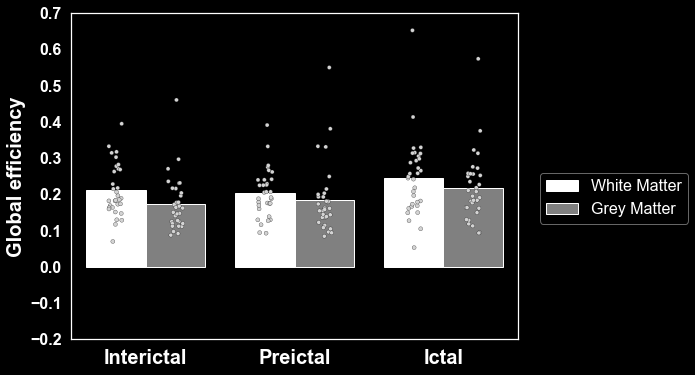

Interictal
Test statistic:  2.9565973326450425
P-value:  0.00590185300032183
Degrees of freedom:  62
Effect size (Cohen's d): 0.5147889003440791

Preictal
Test statistic:  1.060613192417601
P-value:  0.2970595275339466
Degrees of freedom:  62
Effect size (Cohen's d): 0.2194930781848315

Ictal
Test statistic:  2.232203137147153
P-value:  0.03296455855162581
Degrees of freedom:  62
Effect size (Cohen's d): 0.2961143603125767



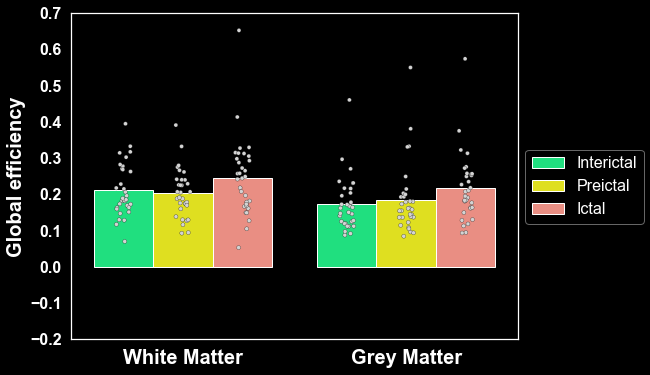

Interictal vs. Preictal White Matter
Test statistic:  1.0953355462565266
P-value:  0.2818069044086944
Degrees of freedom:  62
Effect size (Cohen's d): 0.12476053363791609

Interictal vs. Ictal White Matter
Test statistic:  -1.7075988654150698
P-value:  0.09770877445186016
Degrees of freedom:  62
Effect size (Cohen's d): -0.38665894073088114

Preictal vs. Ictal White Matter
Test statistic:  -2.1793635134358347
P-value:  0.03702451657955217
Degrees of freedom:  62
Effect size (Cohen's d): -0.4943547201517166

Interictal vs. Preictal Grey Matter
Test statistic:  -0.9412511836419477
P-value:  0.35385364149226617
Degrees of freedom:  62
Effect size (Cohen's d): -0.12878979048166742

Interictal vs. Ictal Grey Matter
Test statistic:  -2.2126191947682865
P-value:  0.034420255109436027
Degrees of freedom:  62
Effect size (Cohen's d): -0.5134438879804483

Preictal vs. Ictal Grey Matter
Test statistic:  -1.5733488575558077
P-value:  0.12579001029919337
Degrees of freedom:  62
Effect size (Cohen's

In [694]:
# Filter dataframe
df = ieeg_graph_df[ieeg_graph_df['ieeg_conn_type'] == 'spearman']
df = df[df['freq_band'] == 'alpha']

# Rename variable
df.loc[:,'state'] = df.loc[:,'state'].replace({'interictal': 'Interictal',
                                                  'preictal': 'Preictal',
                                                    'ictal': 'Ictal'})
df.loc[:,'tissue_type'] = df.loc[:,'tissue_type'].replace({'wm': 'White Matter', 'gm': 'Grey Matter'})
df.loc[:,'global_efficiency'] = df.loc[:,'global_efficiency'].replace({'global_efficiency': 'Global efficiency'})
df.loc[:,'modularity'] = df.loc[:,'modularity'].replace({'modularity': 'Modularity'})


############# Plot global efficiency as a bar graph
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x='state', y='global_efficiency', hue='tissue_type', data=df, palette=['white', 'gray'], ci=None)
sns.stripplot(x='state', y='global_efficiency', hue='tissue_type', data=df, palette=['lightgrey','lightgrey','lightgrey','lightgrey','lightgrey','lightgrey'], jitter=True, dodge=True, s=4, edgecolor='black', linewidth=0.25)

# Set the title and axis labels
plt.xticks(fontsize=20, weight='bold')
plt.yticks(fontsize=16, weight='bold')
plt.xlabel('', fontsize=20)
plt.ylabel('Global efficiency', fontsize=20, weight='bold')
plt.ylim([-0.2,0.7])
plt.title('', fontsize=16, weight='bold')

# Extract handles and labels
handles, labels = ax.get_legend_handles_labels()

# Set the legend location and format
plt.legend(handles[2:4], labels[2:4], loc='lower right', fancybox=True, framealpha=0.5, fontsize=16, ncol=1, bbox_to_anchor=(1.4, 0.33))

# Show the plot
plt.show()

# Run paired t-tests comparing global efficiency between tissue types
for state in ['Interictal', 'Preictal', 'Ictal']:

  df_state = df[df['state'] == state]

  # Subset the data by tissue type
  wm_global_efficiency = df_state[df_state['tissue_type'] == 'White Matter']['global_efficiency']
  gm_global_efficiency = df_state[df_state['tissue_type'] == 'Grey Matter']['global_efficiency']

  # Perform the t-test
  t_statistic, p_value = stats.ttest_rel(wm_global_efficiency, gm_global_efficiency)
  effect_size = compute_cohens_d(wm_global_efficiency, gm_global_efficiency)

  # Print the results
  print(state)
  print("Test statistic: ", t_statistic)
  print("P-value: ", p_value)
  print("Degrees of freedom: ", len(wm_global_efficiency) + len(gm_global_efficiency) - 2)
  print("Effect size (Cohen's d):", effect_size)
  print("")

# Regroup by tissue type
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x='tissue_type', y='global_efficiency', hue='state', data=df, palette=['springgreen', 'yellow', 'salmon'], ci=None)
sns.stripplot(x='tissue_type', y='global_efficiency', hue='state', data=df, palette=['lightgrey','lightgrey','lightgrey','lightgrey','lightgrey','lightgrey'], jitter=True, dodge=True, s=4, edgecolor='black', linewidth=0.25)

# Set the title and axis labels
plt.xticks(fontsize=20, weight='bold')
plt.yticks(fontsize=16, weight='bold')
plt.xlabel('', fontsize=20)
plt.ylabel('Global efficiency', fontsize=20, weight='bold')
plt.ylim([-0.2,0.7])
plt.title('', fontsize=16, weight='bold')

# Extract handles and labels
handles, labels = ax.get_legend_handles_labels()

# Set the legend location and format
plt.legend(handles[3:6], labels[3:6], loc='lower right', fancybox=True, framealpha=0.5, fontsize=16, ncol=1, bbox_to_anchor=(1.3, 0.33))

# Show the plot
plt.show()

# Run paired t-tests comparing global efficiency between states, within tissue type
for tissue_type in ['White Matter', 'Grey Matter']:

  df_tissue = df[df['tissue_type'] == tissue_type]

  # Subset the data by state
  interictal_global_efficiency = df_tissue[df_tissue['state'] == 'Interictal']['global_efficiency']
  preictal_global_efficiency = df_tissue[df_tissue['state'] == 'Preictal']['global_efficiency']
  ictal_global_efficiency = df_tissue[df_tissue['state'] == 'Ictal']['global_efficiency']

  # Perform the t-test
  t_statistic, p_value = stats.ttest_rel(interictal_global_efficiency, preictal_global_efficiency)
  effect_size = compute_cohens_d(interictal_global_efficiency, preictal_global_efficiency)

  # Print the results
  print("Interictal vs. Preictal " + tissue_type)
  print("Test statistic: ", t_statistic)
  print("P-value: ", p_value)
  print("Degrees of freedom: ", len(wm_global_efficiency) + len(gm_global_efficiency) - 2)
  print("Effect size (Cohen's d):", effect_size)
  print("")

  # Perform the t-test
  t_statistic, p_value = stats.ttest_rel(interictal_global_efficiency, ictal_global_efficiency)
  effect_size = compute_cohens_d(interictal_global_efficiency, ictal_global_efficiency)

  # Print the results
  print("Interictal vs. Ictal " + tissue_type)
  print("Test statistic: ", t_statistic)
  print("P-value: ", p_value)
  print("Degrees of freedom: ", len(wm_global_efficiency) + len(gm_global_efficiency) - 2)
  print("Effect size (Cohen's d):", effect_size)
  print("")

  # Perform the t-test
  t_statistic, p_value = stats.ttest_rel(preictal_global_efficiency, ictal_global_efficiency)
  effect_size = compute_cohens_d(preictal_global_efficiency, ictal_global_efficiency)

  # Print the results
  print("Preictal vs. Ictal " + tissue_type)
  print("Test statistic: ", t_statistic)
  print("P-value: ", p_value)
  print("Degrees of freedom: ", len(wm_global_efficiency) + len(gm_global_efficiency) - 2)
  print("Effect size (Cohen's d):", effect_size)
  print("")

### Include fMRI global efficiency on same plot

           sub tissue_type  global_efficiency state
1  sub-RID0037  wm          0.253863           fMRI
3  sub-RID0037  gm          0.282183           fMRI
5  sub-RID0490  wm          0.199612           fMRI
7  sub-RID0490  gm          0.275238           fMRI
9  sub-RID0031  wm          0.248946           fMRI
            sub tissue_type       state  global_efficiency
1   sub-RID0037  wm          interictal  0.171142         
19  sub-RID0037  wm          preictal    0.149729         
37  sub-RID0037  wm          ictal       0.126501         
55  sub-RID0037  gm          interictal  0.108185         
73  sub-RID0037  gm          preictal    0.070940         


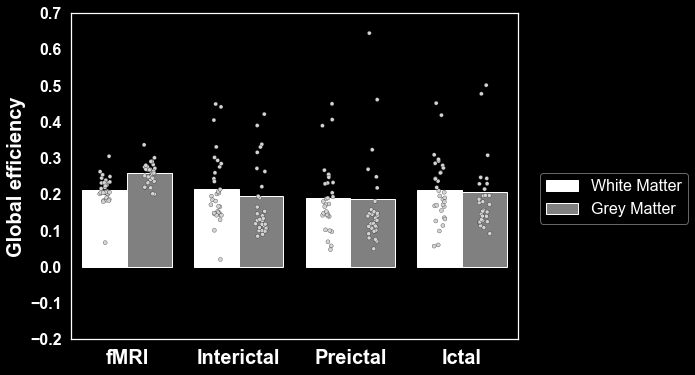

In [695]:
# Filter dataframe
fmri_df = fmri_graph_df[fmri_graph_df['fmri_conn_type'] == 'spearman']
fmri_df = fmri_df.drop(['radius', 'fmri_conn_type', 'cluster_coef', 'modularity'], axis=1)
fmri_df['state'] = 'fMRI'

print(fmri_df.head())

ieeg_df = ieeg_graph_df[ieeg_graph_df['ieeg_conn_type'] == 'spearman']
ieeg_df = ieeg_df[ieeg_df['freq_band'] == 'broadband']
ieeg_df = ieeg_df.drop(['freq_band', 'ieeg_conn_type', 'cluster_coef', 'modularity'], axis=1)

print(ieeg_df.head())

# Merge data frames
df = pd.concat([fmri_df, ieeg_df], axis=0)

# # Rename variable
df.loc[:,'state'] = df.loc[:,'state'].replace({'interictal': 'Interictal',
                                                   'preictal': 'Preictal',
                                                     'ictal': 'Ictal'})
df.loc[:,'tissue_type'] = df.loc[:,'tissue_type'].replace({'wm': 'White Matter', 'gm': 'Grey Matter'})
df.loc[:,'global_efficiency'] = df.loc[:,'global_efficiency'].replace({'global_efficiency': 'Global efficiency'})

############# Plot global efficiency as a bar graph
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x='state', y='global_efficiency', hue='tissue_type', data=df, palette=['white', 'gray'], ci=None)
sns.stripplot(x='state', y='global_efficiency', hue='tissue_type', data=df, palette=['lightgrey','lightgrey','lightgrey','lightgrey','lightgrey','lightgrey'], jitter=True, dodge=True, s=4, edgecolor='black', linewidth=0.25)

# Set the title and axis labels
plt.xticks(fontsize=20, weight='bold')
plt.yticks(fontsize=16, weight='bold')
plt.xlabel('', fontsize=20)
plt.ylabel('Global efficiency', fontsize=20, weight='bold')
plt.ylim([-0.2,0.7])
plt.title('', fontsize=16, weight='bold')

# Extract handles and labels
handles, labels = ax.get_legend_handles_labels()

# Set the legend location and format
plt.legend(handles[2:4], labels[2:4], loc='lower right', fancybox=True, framealpha=0.5, fontsize=16, ncol=1, bbox_to_anchor=(1.4, 0.33))

# Show the plot
plt.show()


### fMRI

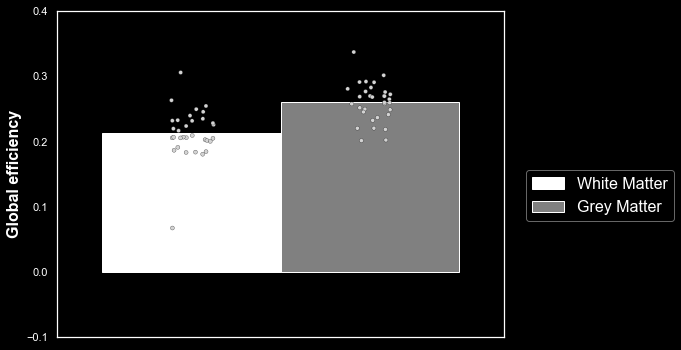

In [698]:
# Filter dataframe
df = fmri_graph_df[fmri_graph_df['fmri_conn_type'] == 'spearman']

# Exclude subjects sub-RID0143 and sub-RID0032
#df = df[df['sub'] != 'sub-RID0143']
#df = df[df['sub'] != 'sub-RID0032']

# Rename variable
df.loc[:,'tissue_type'] = df.loc[:,'tissue_type'].replace({'wm': 'White Matter', 'gm': 'Grey Matter'})


############# Plot global efficiency as a bar graph
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x='radius', y='global_efficiency', hue='tissue_type', data=df, palette=['white', 'gray'], ci=None)
sns.stripplot(x='radius', y='global_efficiency', hue='tissue_type', data=df, palette=['lightgrey','lightgrey','lightgrey','lightgrey','lightgrey','lightgrey'], jitter=True, dodge=True, s=4, edgecolor='black', linewidth=0.25)

# Set the title and axis labels
plt.xticks(fontsize=16, weight='bold')
plt.xlabel('', fontsize=16)
plt.ylabel('Global efficiency', fontsize=16, weight='bold')
plt.ylim([-0.1,0.4])
plt.title('', fontsize=16, weight='bold')

# Extract handles and labels
handles, labels = ax.get_legend_handles_labels()

# Remove x-ticks
plt.xticks([])

# Set the legend location and format
plt.legend(handles[2:4], labels[2:4], loc='lower right', fancybox=True, framealpha=0.5, fontsize=16, ncol=1, bbox_to_anchor=(1.4, 0.33))

# Show the plot
plt.show()

